In [45]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import re
# Carregar os dados
data = pd.read_excel(r'DADOS BRUTOS/ECQ_ABR_25.xlsx')
data = data[data['ANF'] == 83]
data = data[['ANF', 'MUNICIPIO', 'ENDERECO_ID', 'TESTES_ECQ', 'ECQ']]
data['TESTES_ECQ_OK'] = (data['TESTES_ECQ'] * data['ECQ']).round(0)
data.drop(columns=['ECQ'], inplace=True)
# Agrupar por ANF e Município (DEFINA AQUI)
grouped = data.groupby(['ANF', 'MUNICIPIO'])
data['ANF'] = data['ANF'].astype(int)
data



/home/tiago/anaconda3/envs/pymc_env/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,ANF,MUNICIPIO,ENDERECO_ID,TESTES_ECQ,TESTES_ECQ_OK
2374,83,ARACAGI,PBAAG_0001,2.0,0.0
2375,83,ARARUNA,PBAAN_0001,23.0,16.0
2376,83,AGUA BRANCA,PBABW_0001,7.0,7.0
2377,83,AREIAL,PBAEA_0001,23.0,17.0
2378,83,AREIA,PBAEI_0001,103.0,77.0
...,...,...,...,...,...
2781,83,UMBUZEIRO,PBUUZ_0001,15.0,0.0
2782,83,VISTA SERRANA,PBVASR0001,1.0,0.0
2783,83,VIEIROPOLIS,PBVIEI0001,12.0,0.0
2784,83,VARZEA,PBVRA_0001,18.0,16.0


In [46]:
trace = az.from_netcdf(r"modelos/trace_ECQ_normal_pyMC_ABR25.nc")

In [47]:
rows = []
for (anf, municipio), group in grouped:
    var_name = f"theta_site_{anf}_{municipio}"
    if var_name in trace.posterior.data_vars:
        # Obter amostras do theta_site (dimensão: chain, draw, site_idx)
        theta_site_samples = trace.posterior[var_name]  # Formato (2, 2000, n_sites)
        
        # Extrair ENDERECO_IDs correspondentes aos índices dos sites
        endereco_ids = group['ENDERECO_ID'].tolist()
        
        # Iterar sobre cada site (ENDERECO_ID)
        for site_idx, endereco_id in enumerate(endereco_ids):
            # Extrair amostras para o site específico
            site_samples = theta_site_samples[:, :, site_idx].values.flatten()
            
            # Calcular estatísticas
            mean = site_samples.mean()
            std = site_samples.std()
            hdi_3, hdi_97 = az.hdi(site_samples, hdi_prob=0.94)
            
            rows.append({
                "ANF": anf,
                "MUNICIPIO": municipio,
                "ENDERECO_ID": endereco_id,
                "mean": round(mean, 2),
                "stddev": round(std , 2),
                "hdi_inf": round(hdi_3 , 2),
                "hdi_sup": round(hdi_97, 2)
            })


summary_df = pd.DataFrame(rows)

1. impacto_acumulado (Impacto Acumulado)
O que é: Soma cumulativa da métrica de impacto (impacto) dos sites, ordenados do maior para o menor impacto (priorizando os piores sites).

Interpretação:
"Se corrigirmos os primeiros N sites desta lista, qual é o impacto total esperado na melhoria do ECQ do município?"

impacto_acumulado = sum(impacto_dos_sites_priorizados)

2. ganho_potencial_ecq (Ganho Potencial de ECQ)
O que é: Representa quanto o ECQ médio do município poderia aumentar se os sites prioritários fossem corrigidos, expresso como uma proporção do ECQ atual.

Interpretação:
"Se corrigirmos os primeiros N sites, qual é o aumento percentual esperado no ECQ médio do município?"

ganho_potencial_ecq = impacto_acumulado / mean_municipio

In [48]:
# 3. Extrair estatísticas dos sites
rows = []
for (anf, municipio), group in grouped:
    var_name = f"theta_site_{anf}_{municipio}"
    if var_name in trace.posterior.data_vars:
        theta_site_samples = trace.posterior[var_name]
        endereco_ids = group['ENDERECO_ID'].tolist()
        
        for site_idx, endereco_id in enumerate(endereco_ids):
            samples = theta_site_samples[..., site_idx].values.flatten()
            
            rows.append({
                "ANF": anf,
                "MUNICIPIO": municipio,
                "ENDERECO_ID": endereco_id,
                "mean_site": samples.mean(),
                "stddev_site": samples.std(),
                "hdi_inf": az.hdi(samples, hdi_prob=0.95)[0],
                "hdi_sup": az.hdi(samples, hdi_prob=0.95)[1]
            })

summary_df = pd.DataFrame(rows)

# 4. Extrair ECQ dos municípios (mu_municipio)
municipio_rows = []
for (anf, municipio) in grouped.groups.keys():
    var_name = f"mu_municipio_{anf}_{municipio}"
    if var_name in trace.posterior.data_vars:
        samples = trace.posterior[var_name].values.flatten()
        municipio_rows.append({
            "ANF": anf,
            "MUNICIPIO": municipio,
            "mean_municipio": samples.mean(),
            "stddev_municipio": samples.std(),
            "hdi_inf_Mun": az.hdi(samples, hdi_prob=0.95)[0],
            "hdi_sup_Mun": az.hdi(samples, hdi_prob=0.95)[1]
        })

municipio_stats = pd.DataFrame(municipio_rows)

In [49]:
# ========================================================
# 5. Juntar todos os dados e calcular FALHAS_ECQ (CORRIGIDO)
# ========================================================
merged_df = pd.merge(
    summary_df,
    data[['ANF', 'MUNICIPIO', 'ENDERECO_ID', 'TESTES_ECQ', 'TESTES_ECQ_OK']],
    on=['ANF', 'MUNICIPIO', 'ENDERECO_ID'],
    how='inner'
)

# Adicionar mean_municipio do municipio_stats
merged_df = pd.merge(
    merged_df,
    municipio_stats[['ANF', 'MUNICIPIO', 'mean_municipio', 'hdi_inf_Mun', 'hdi_sup_Mun']],  # <--- Adicione esta linha
    on=['ANF', 'MUNICIPIO'],
    how='left'
)

# Calcular FALHAS_ECQ
merged_df['FALHAS_ECQ'] = merged_df['TESTES_ECQ'] - merged_df['TESTES_ECQ_OK']

# 6. Calcular métricas de impacto REVISADAS
# Normalizar falhas por município (0 a 1)
merged_df['FALHAS_ECQ_norm'] = merged_df.groupby(['ANF', 'MUNICIPIO'])['FALHAS_ECQ'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8)
)

# Nova métrica de impacto: potencial de ganho proporcional às falhas
merged_df['impacto'] = (
    (1 - merged_df['mean_site']) *  # Potencial máximo de melhoria (0 a 1)
    merged_df['FALHAS_ECQ_norm']    # Peso pelo volume de falhas normalizado
)


In [50]:

# 7. Calcular total de testes por município
merged_df['total_testes_municipio'] = merged_df.groupby(
    ['ANF', 'MUNICIPIO']
)['TESTES_ECQ'].transform('sum')

# 8. Ordenar e acumular impacto
merged_df['rank'] = merged_df.groupby(['ANF', 'MUNICIPIO'])['impacto'].rank(
    ascending=False, method='first'
)

# merged_df['impacto_acumulado'] = merged_df.groupby(
#     ['ANF', 'MUNICIPIO']
# )['impacto'].transform(lambda x: x.sort_values(ascending=False).cumsum())
# Nova fórmula: Ganho potencial por site (não acumulado)
# merged_df['ganho_potencial_ecq'] = (
#     (1 - merged_df['mean_site']).clip(lower=0) *  # Evita valores negativos
#     merged_df['FALHAS_ECQ'] / 
#     merged_df['total_testes_municipio'] 
# ) * 100

# Impacto = falhas brutas
merged_df['incECQ'] = merged_df['FALHAS_ECQ'] / merged_df['total_testes_municipio']


merged_df['rank'] = merged_df.groupby(['ANF', 'MUNICIPIO'])['incECQ'].rank(
    ascending=False, method='first'
)

In [51]:

# ========================================================
# 9. Saída final
# ========================================================
# 10. Saída final

final_df = merged_df[[
    'ANF', 'MUNICIPIO', 'ENDERECO_ID', 
    'hdi_inf','mean_site', 'hdi_sup', 'hdi_inf_Mun', 'mean_municipio' ,'hdi_sup_Mun',
    'FALHAS_ECQ', 'TESTES_ECQ', 'TESTES_ECQ_OK','incECQ', 'rank', 'impacto' 
    # HDI intervals for sites
   # Test counts
]].sort_values(
    by=['ANF', 'MUNICIPIO', 'rank'],
    ascending=[True, True, True]
)

# # Rename HDI columns for clarity
# final_df = final_df.rename(columns={
#     'hdi_inf_x': 'hdi_inf',
#     'hdi_sup_x': 'hdi_sup'
# })


In [52]:

# Verificação final do ranking
test_group = final_df.groupby(['ANF', 'MUNICIPIO']).first()
assert (test_group['rank'] == 1).all(), "Problema no ranking!"

# ========================================================
# 10. Exportar resultados
# ========================================================
final_df.to_excel("priorizacao_sites_ECQ_final.xlsx", index=False)
print("Análise concluída! Resultados salvos em 'priorizacao_sites_ECQ_pyMC_final.xlsx'")

Análise concluída! Resultados salvos em 'priorizacao_sites_ECQ_pyMC_final.xlsx'


In [54]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

<Axes: title={'center': 'mu_municipio_83.0_PATOS'}>

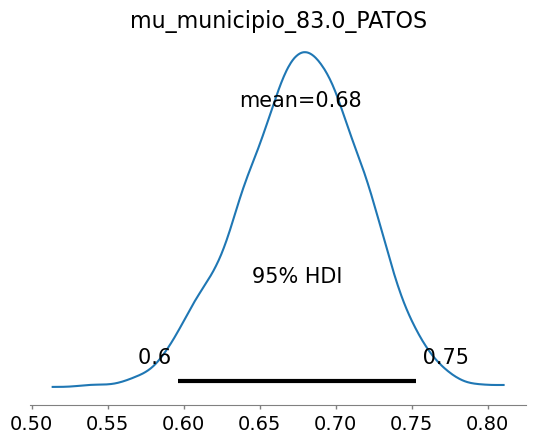

In [55]:
az.plot_posterior(trace, var_names=["mu_municipio_83.0_PATOS"],hdi_prob=0.95)

### ANALISE ANF 83 ###
------


In [81]:
import os

# Path to the directory containing Excel files
result_path = "Output/"

# List to store dataframes
dfs = []

# Iterate through all files in the directory
for file in os.listdir(result_path):
    if file.endswith(".xlsx"):
        file_path = os.path.join(result_path, file)
        dfs.append(pd.read_excel(file_path))

# Concatenate all dataframes
concatenated_df = pd.concat(dfs, ignore_index=True)

# Display the concatenated dataframe
concatenated_df.to_excel('consolidado_83.xlsx')

In [82]:
concatenated_df[['MUNICIPIO', 'hdi_inf_Mun', 'mean_municipio', 'hdi_sup_Mun', 'month']]

,MUNICIPIO,hdi_inf_Mun,mean_municipio,hdi_sup_Mun,month
0,AGUA BRANCA,1.259578e-01,0.454465,0.786252,2025-01-01
1,AGUIAR,1.599964e-01,0.481616,0.836240,2025-01-01
2,ALAGOA GRANDE,2.103395e-01,0.545433,0.859711,2025-01-01
3,ALAGOA NOVA,2.660470e-05,0.213668,0.531093,2025-01-01
4,ALCANTIL,3.033805e-03,0.363526,0.754331,2025-01-01
...,...,...,...,...,...
2849,UIRAUNA,1.037682e-01,0.407728,0.737812,2024-12-01
2850,UMBUZEIRO,3.176162e-02,0.338303,0.706603,2024-12-01
2851,VARZEA,3.103825e-01,0.652684,0.945268,2024-12-01
2852,VIEIROPOLIS,2.811227e-09,0.164037,0.504617,2024-12-01


In [83]:
# Step 2: Select the required columns
filtered = concatenated_df[['MUNICIPIO', 'hdi_inf_Mun', 'mean_municipio', 'hdi_sup_Mun', 'month']].copy()
# Suppress the SettingWithCopyWarning by creating a copy of the filtered DataFrame

filtered.drop_duplicates(inplace=True)

In [84]:
filtered

,MUNICIPIO,hdi_inf_Mun,mean_municipio,hdi_sup_Mun,month
0,AGUA BRANCA,1.259578e-01,0.454465,0.786252,2025-01-01
1,AGUIAR,1.599964e-01,0.481616,0.836240,2025-01-01
2,ALAGOA GRANDE,2.103395e-01,0.545433,0.859711,2025-01-01
3,ALAGOA NOVA,2.660470e-05,0.213668,0.531093,2025-01-01
4,ALCANTIL,3.033805e-03,0.363526,0.754331,2025-01-01
...,...,...,...,...,...
2849,UIRAUNA,1.037682e-01,0.407728,0.737812,2024-12-01
2850,UMBUZEIRO,3.176162e-02,0.338303,0.706603,2024-12-01
2851,VARZEA,3.103825e-01,0.652684,0.945268,2024-12-01
2852,VIEIROPOLIS,2.811227e-09,0.164037,0.504617,2024-12-01


In [87]:
# Filter the concatenated_df for the latest and first month
latest_month = filtered['month'].max()
first_month = filtered['month'].min()

# Filter rows for the latest and first month
latest_data = filtered[filtered['month'] == latest_month]
first_data = filtered[concatenated_df['month'] == first_month]

# Merge the two datasets on MUNICIPIO to compare hdi_inf_Mun and mean_municipio
comparison = pd.merge(
    latest_data[['MUNICIPIO', 'hdi_inf_Mun']],
    first_data[['MUNICIPIO', 'mean_municipio']],
    on='MUNICIPIO'
)

# Filter MUNICIPIO where hdi_inf_Mun from the latest month is greater than mean_municipio from the first month
result = comparison[comparison['hdi_inf_Mun'] > comparison['mean_municipio']]

# Display the MUNICIPIOs
lista = result['MUNICIPIO'].tolist()

/tmp/ipykernel_756/2434785048.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  first_data = filtered[concatenated_df['month'] == first_month]


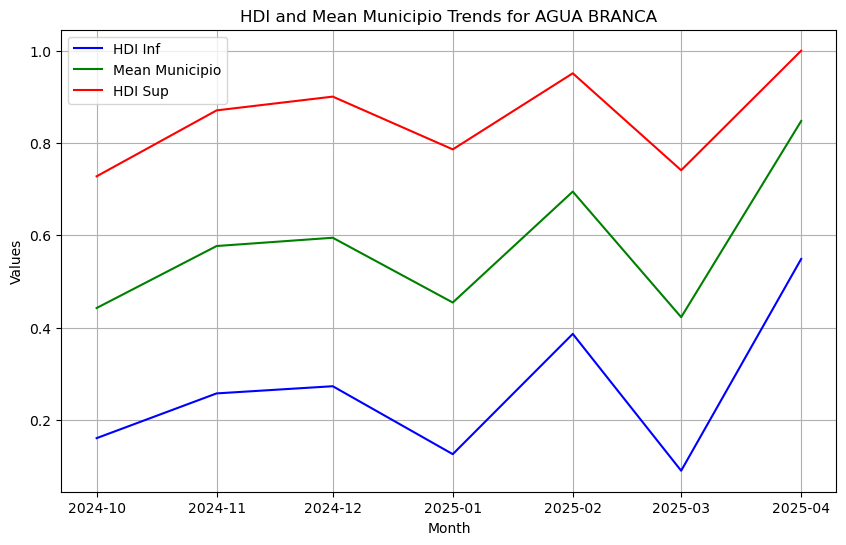

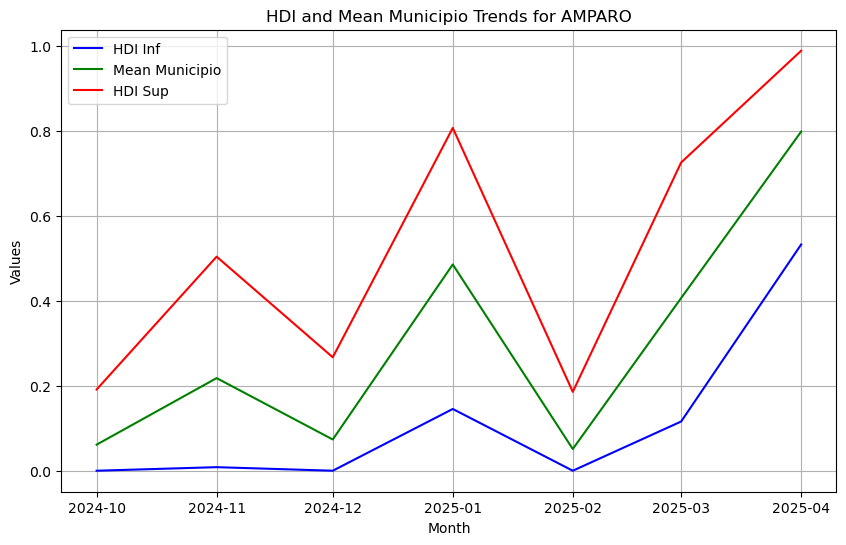

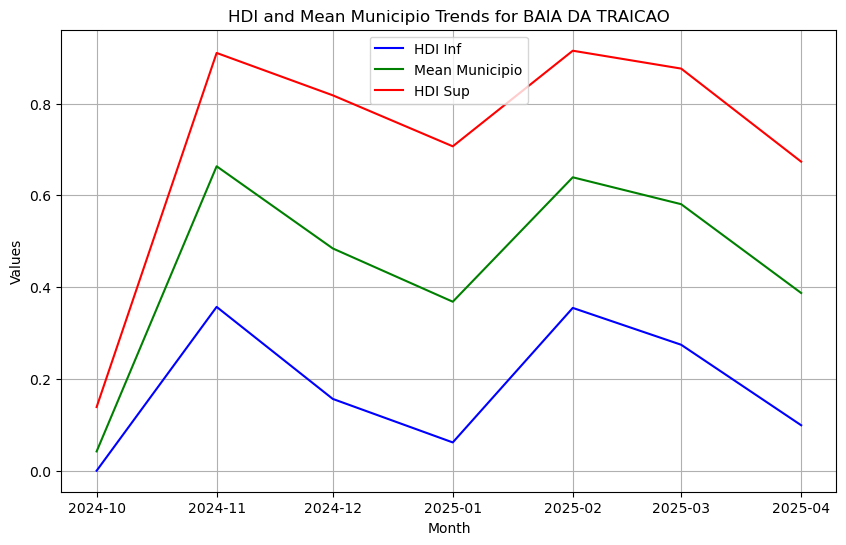

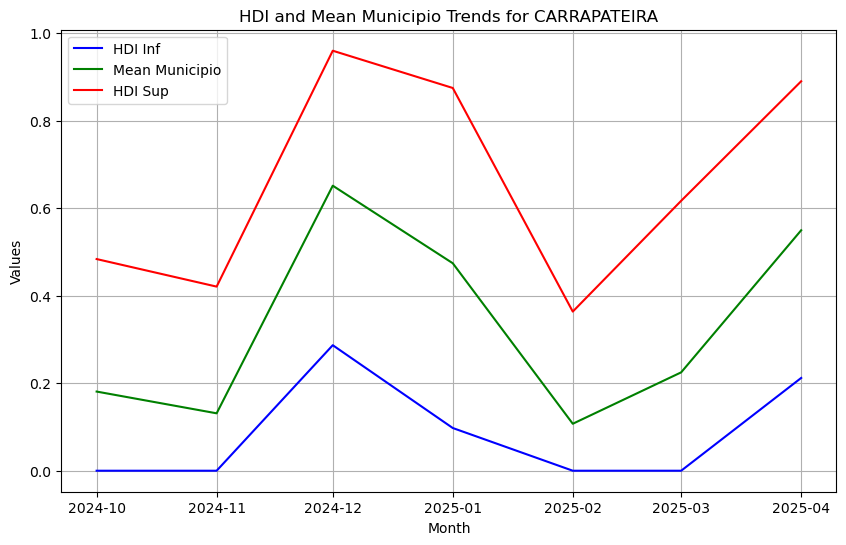

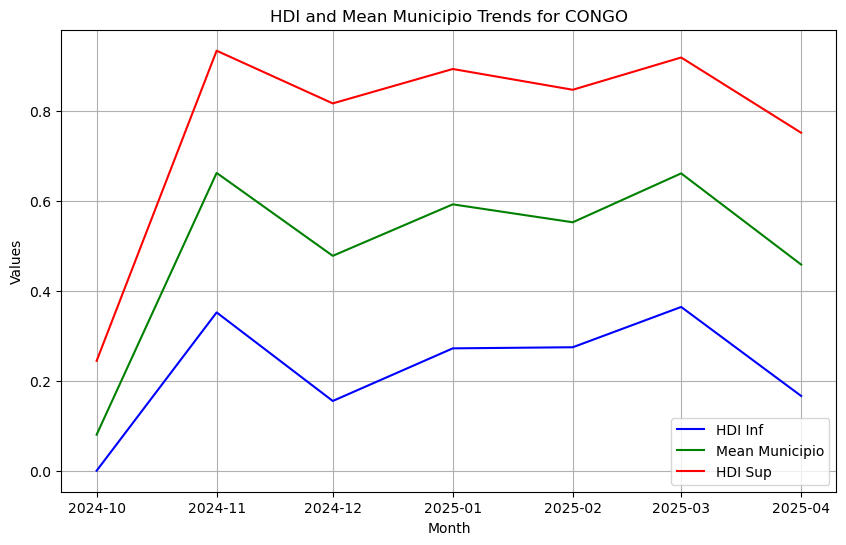

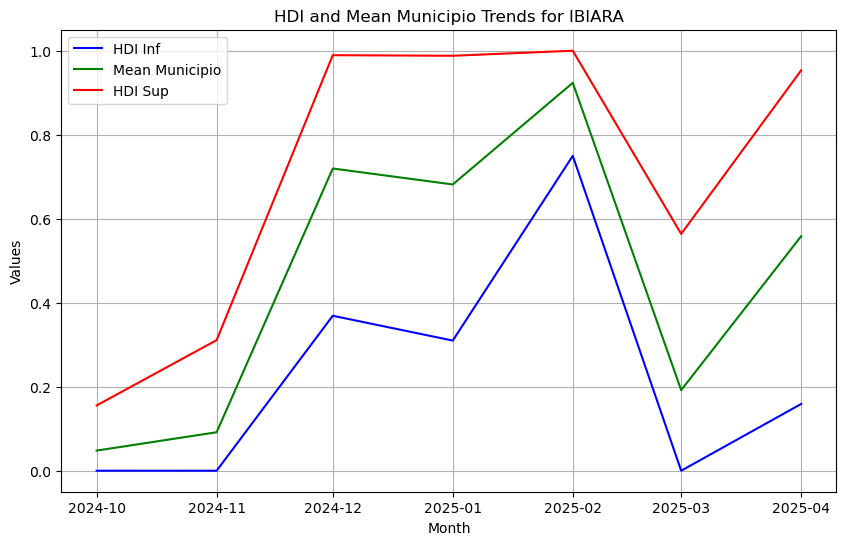

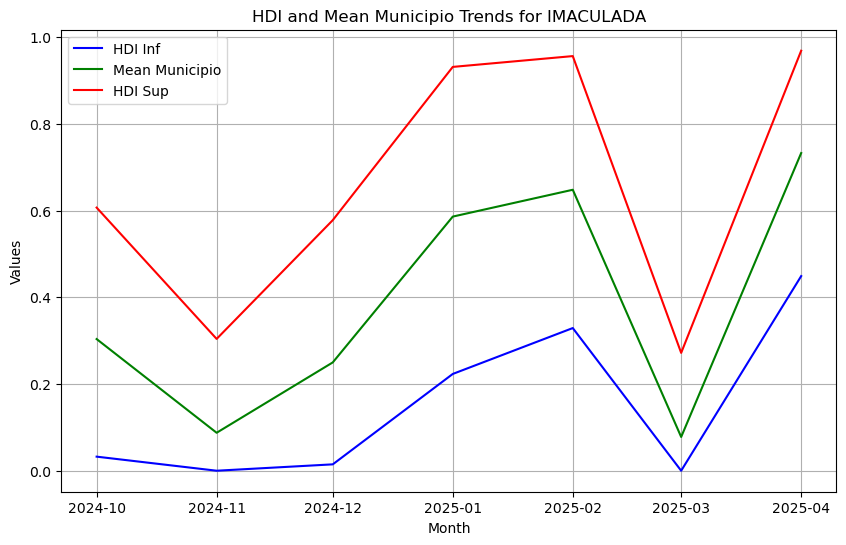

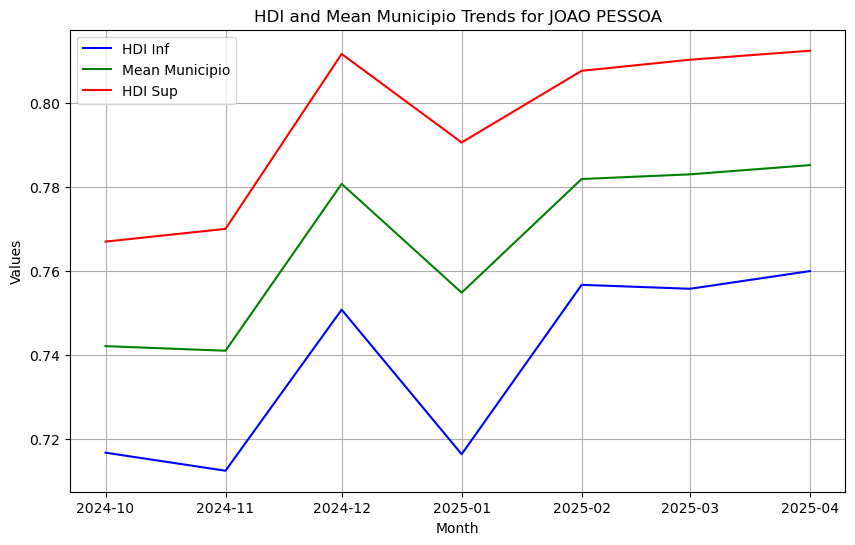

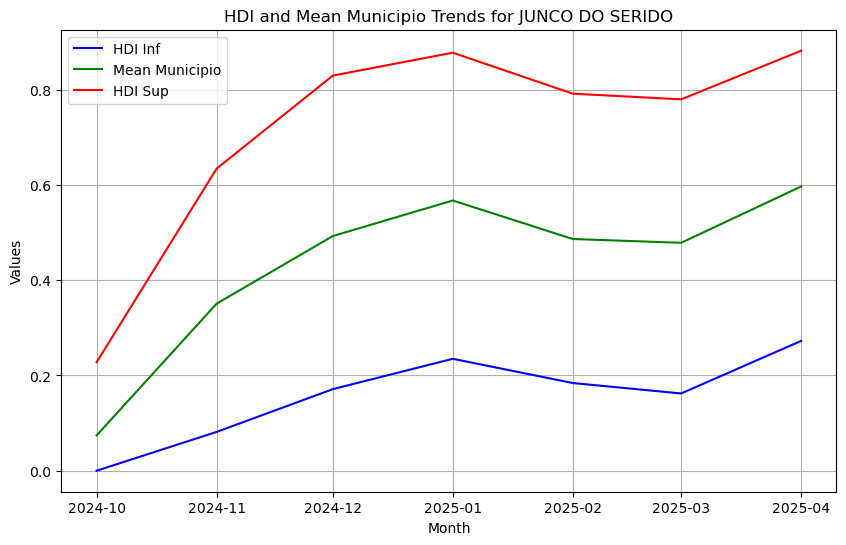

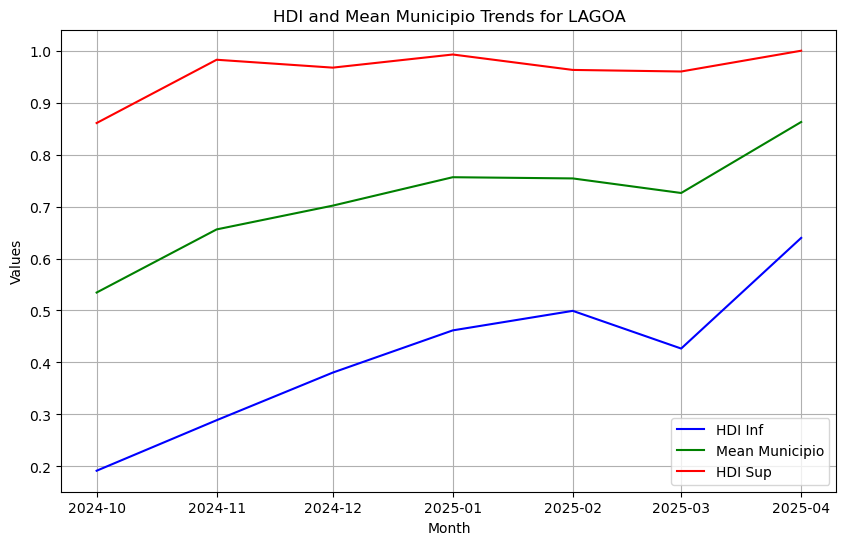

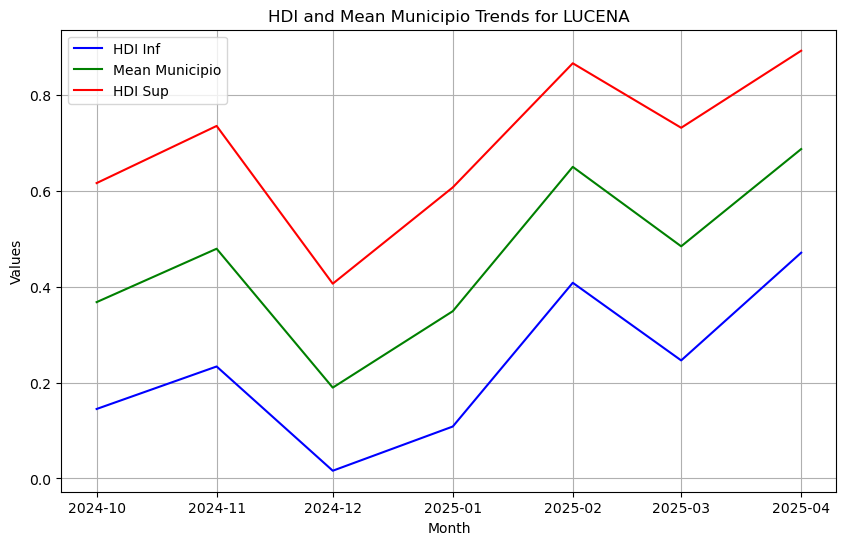

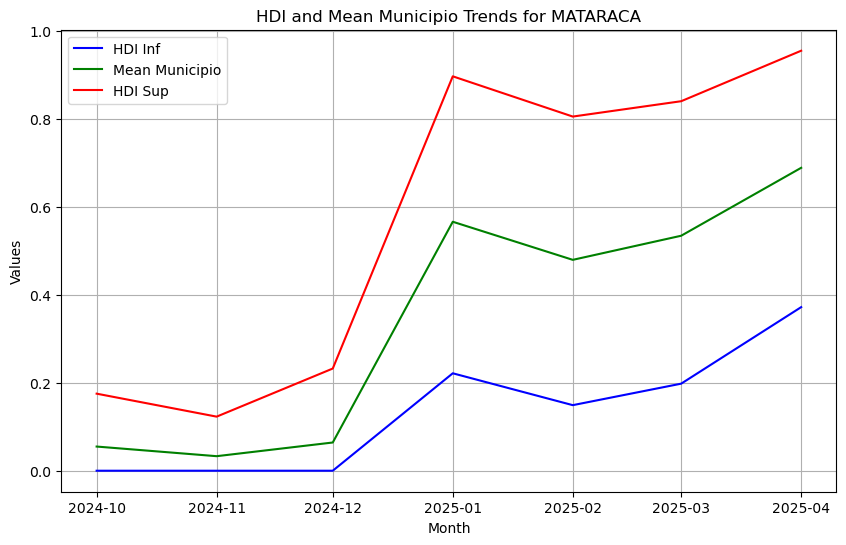

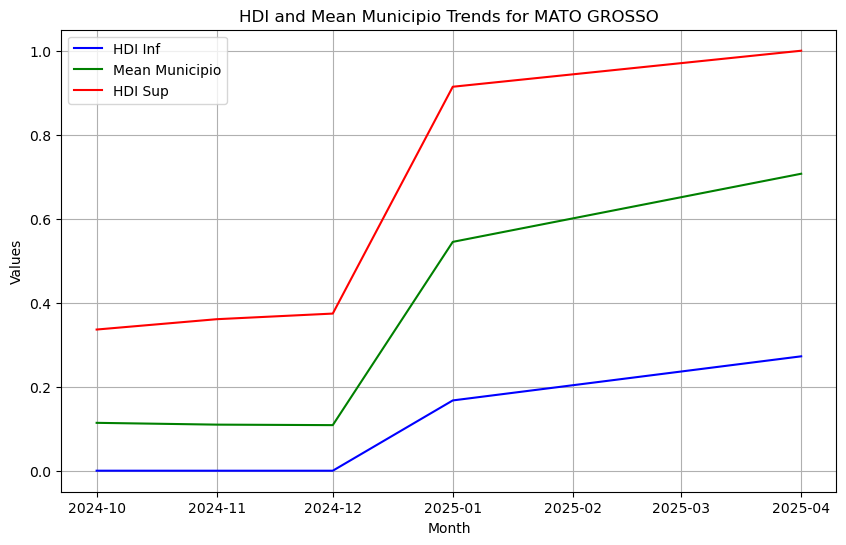

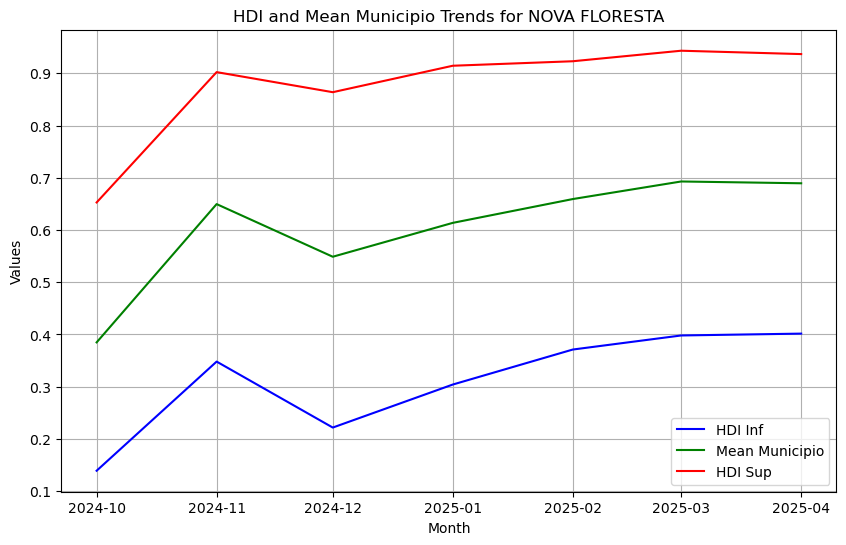

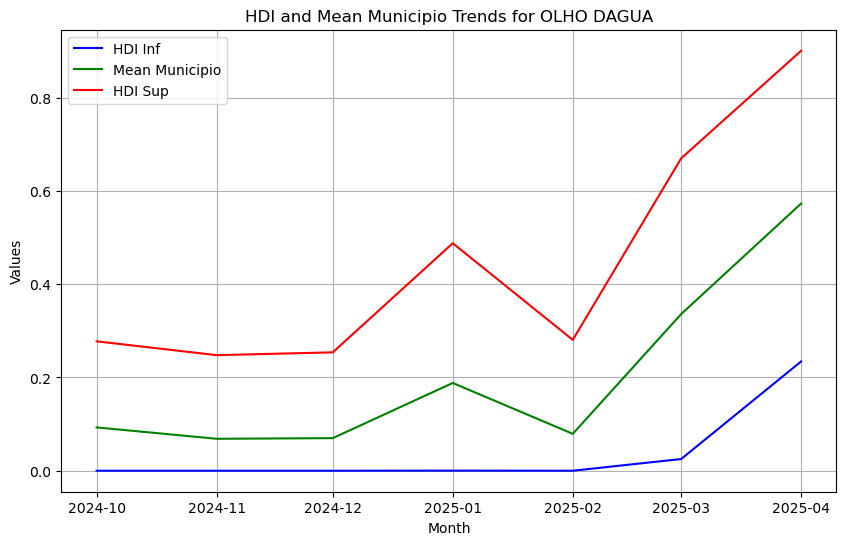

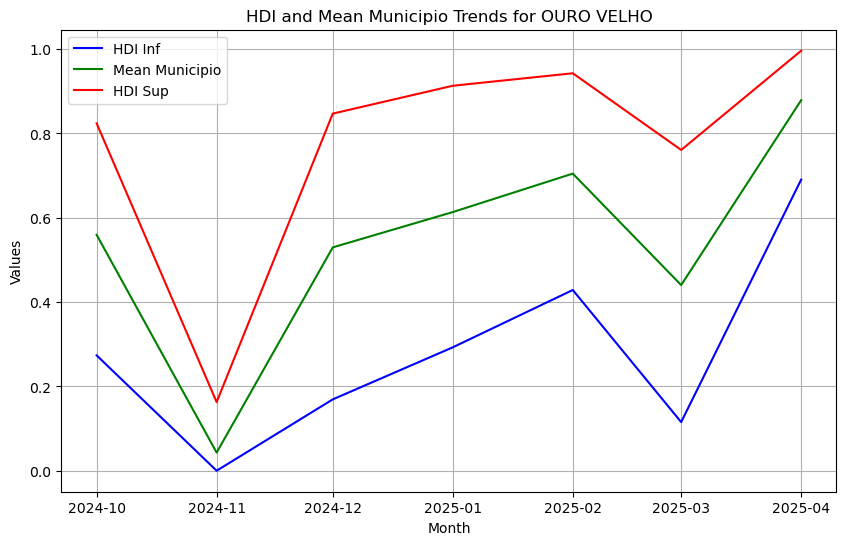

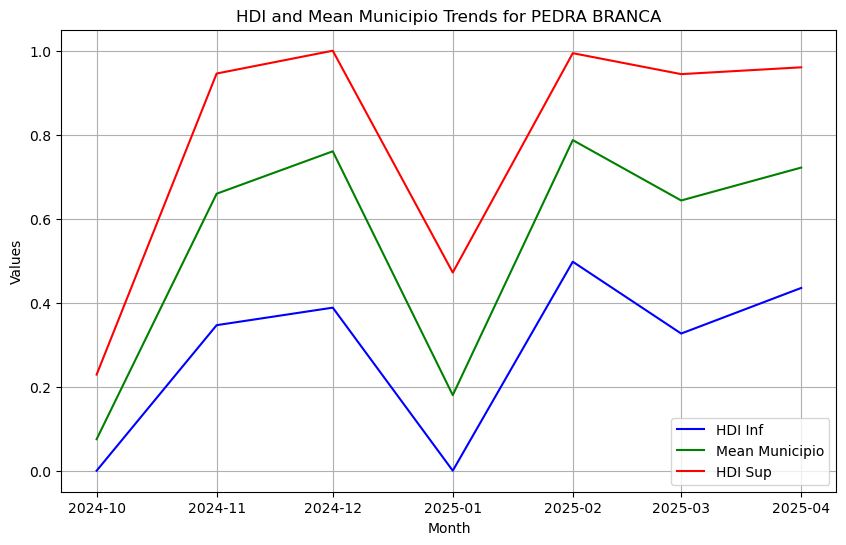

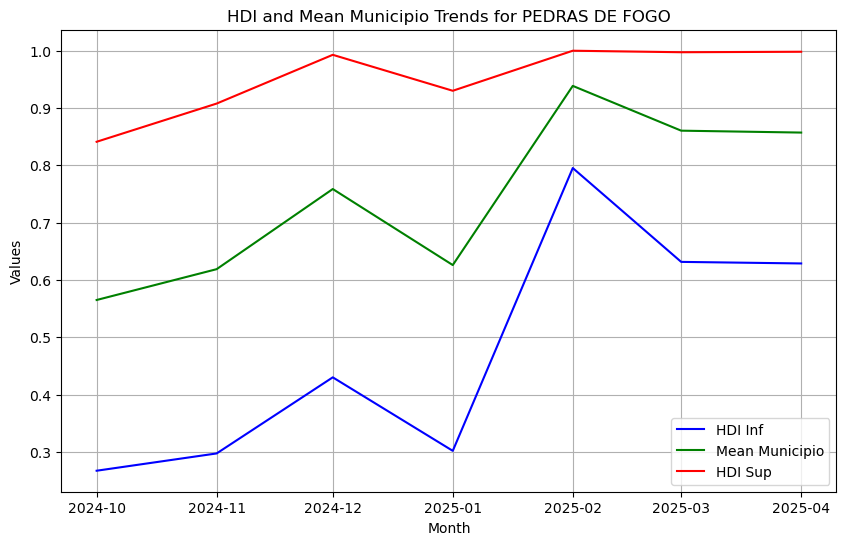

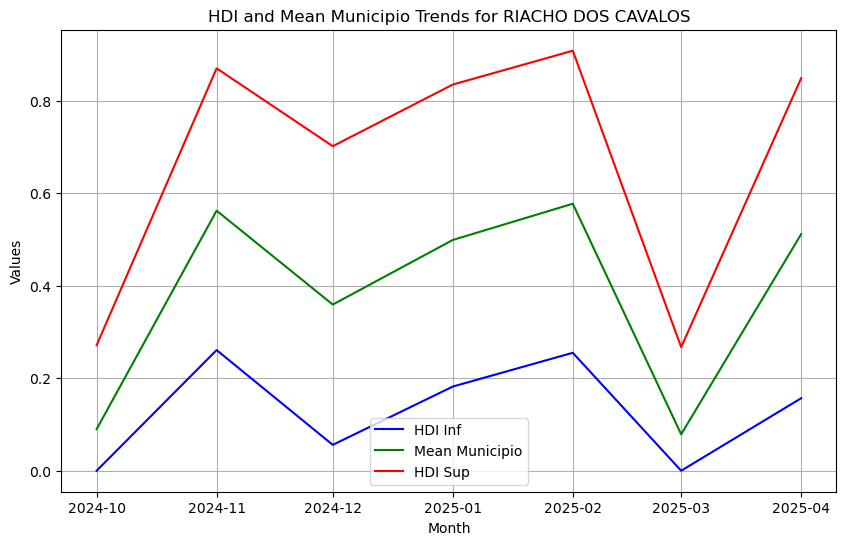

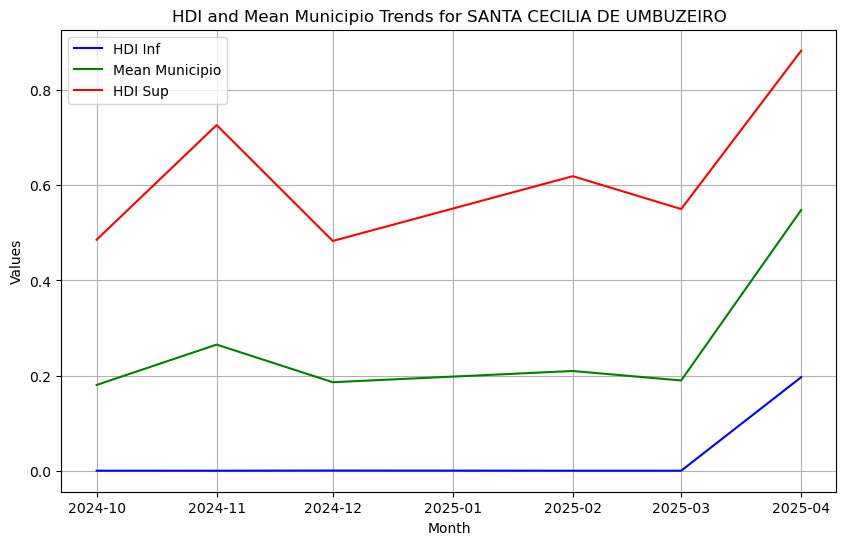

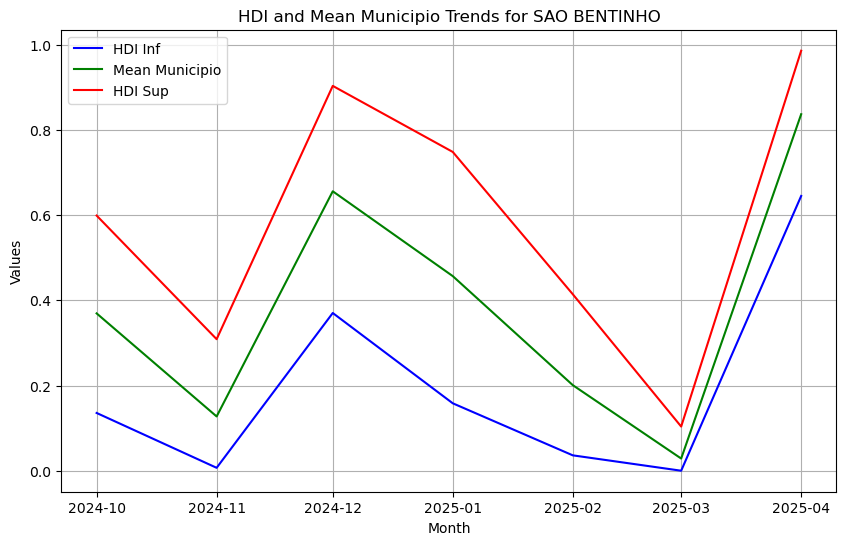

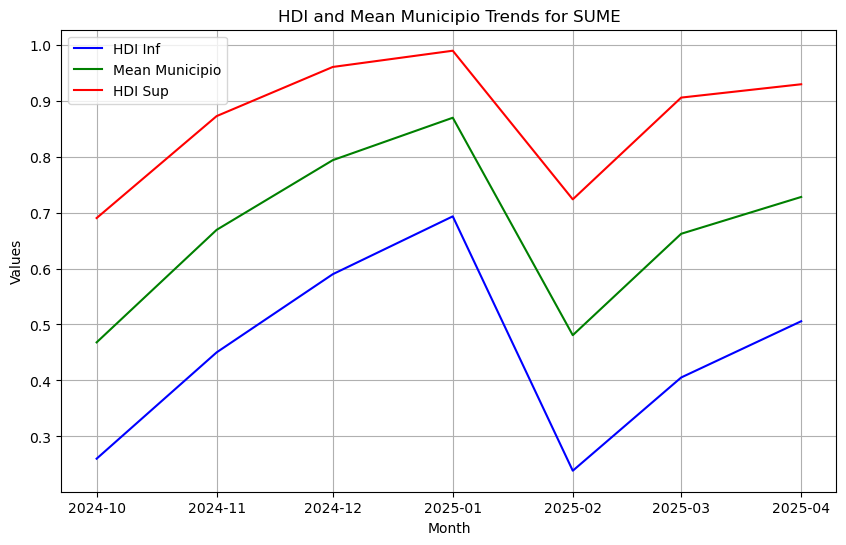

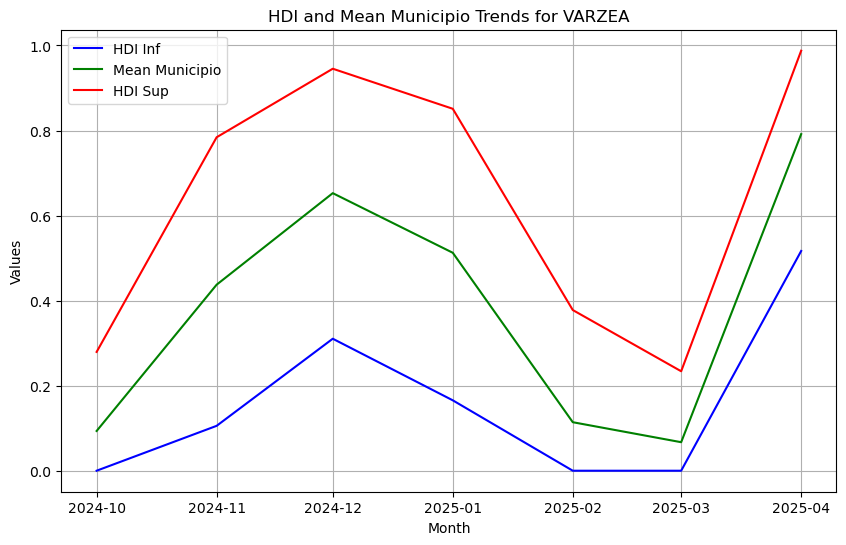

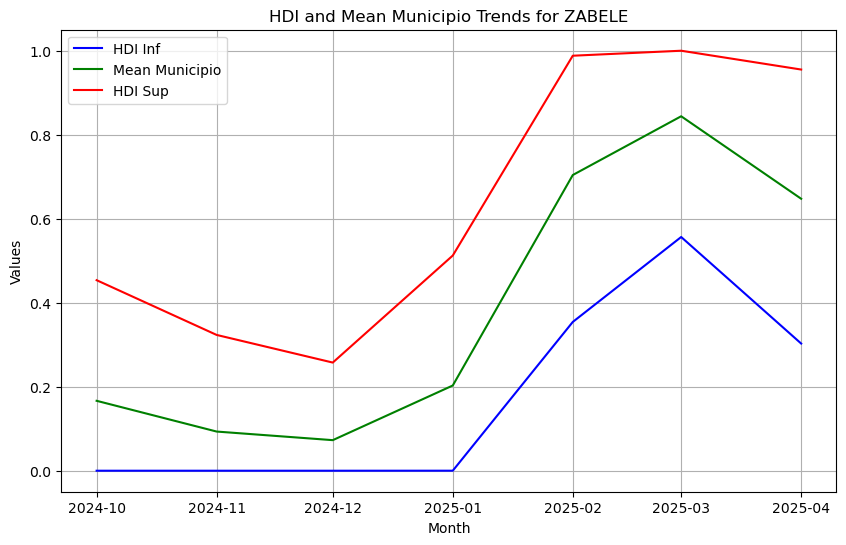

In [88]:
import matplotlib.pyplot as plt

# Iterate through each MUNICIPIO in the lista
for municipio in lista:
    # Step 1: Filter the concatenated_df dataframe for the selected MUNICIPIO
    filtered = concatenated_df[concatenated_df['MUNICIPIO'] == municipio]

    # Ensure 'month' is sorted for proper plotting
    filtered = filtered.sort_values(by='month')

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(filtered['month'], filtered['hdi_inf_Mun'], label='HDI Inf', color='blue')
    plt.plot(filtered['month'], filtered['mean_municipio'], label='Mean Municipio', color='green')
    plt.plot(filtered['month'], filtered['hdi_sup_Mun'], label='HDI Sup', color='red')

    # Add labels, legend, and title
    plt.xlabel('Month')
    plt.ylabel('Values')
    plt.title(f'HDI and Mean Municipio Trends for {municipio}')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()
